# Projekt zaliczeniowy - Przetwarzanie obrazów cyfrowych
Autor: **Patryk Ciepiela**

In [1]:
# Ładowanie bibliotek

import numpy as np
import matplotlib.pyplot as plt
from skimage import segmentation, morphology, io, img_as_ubyte
from skimage.color import rgb2gray
import cv2
import warnings

In [2]:
COLOR_FOREGROUND = 255
COLOR_BACKGROUND = 0
DEBUG = True
if not DEBUG:
    warnings.filterwarnings('ignore')

In [26]:
# Metody pomocnicze
def segment():
    return None

# metoda wyświetlająca obraz w notatniku
def showimg(img, title="Obraz", verbose=False, cmap="gray"):
    if verbose:
        print(img.shape, img.dtype)
    plt.figure(figsize=(15,10))
    plt.imshow(img, cmap=cmap)
    plt.axis('off')
    plt.suptitle(title)
    plt.show()
    
def dist_transform(img, min_dist=48):
    dtimg = np.zeros_like(img, dtype=np.uint8)
    helperimg = cv2.distanceTransform(processedimg, distanceType=cv2.DIST_L2, maskSize=3)
    for i in range(helperimg.shape[0]):
        for j in range(helperimg.shape[1]):
            if helperimg[i][j] > min_dist:
                dtimg[i][j] = 255
    return dtimg

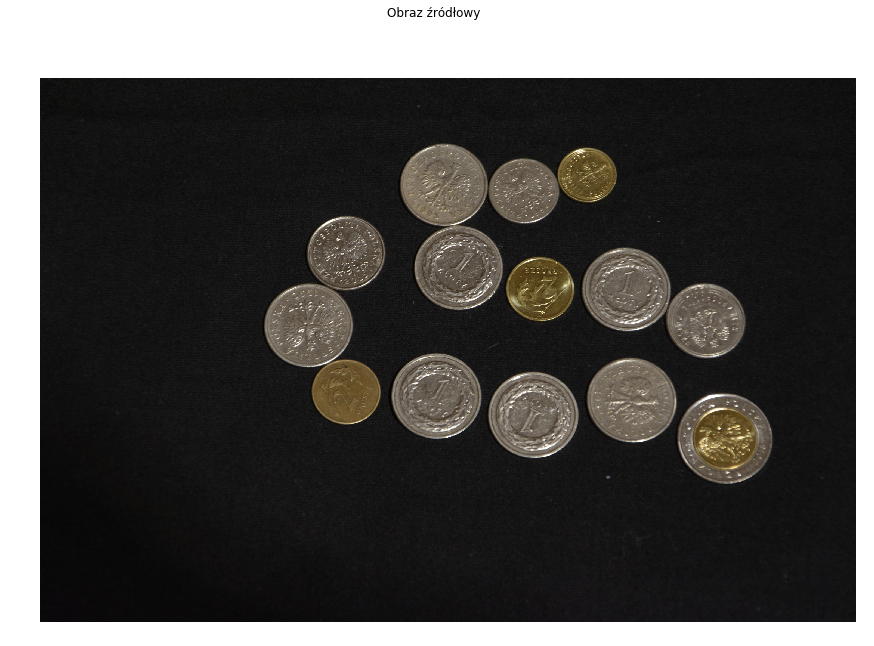

C:\Users\Machina\Anaconda3\envs\py36\lib\site-packages\skimage\util\dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


In [4]:
sourceimg = io.imread("source.jpg")
showimg(sourceimg, title="Obraz źródłowy")

processedimg = sourceimg.copy()
processedimg = img_as_ubyte(rgb2gray(processedimg))
processedimg = cv2.blur(processedimg, (5,5))

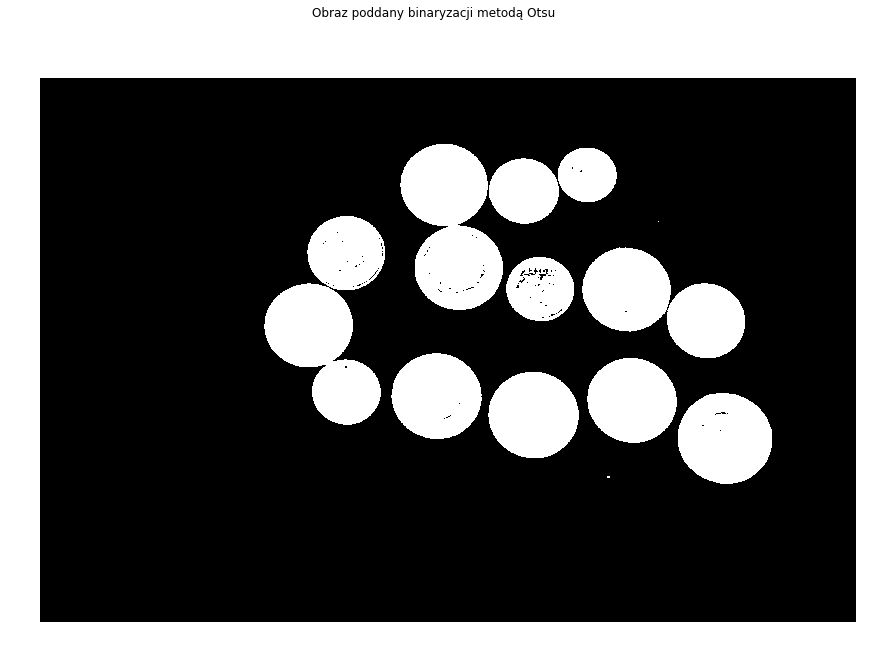

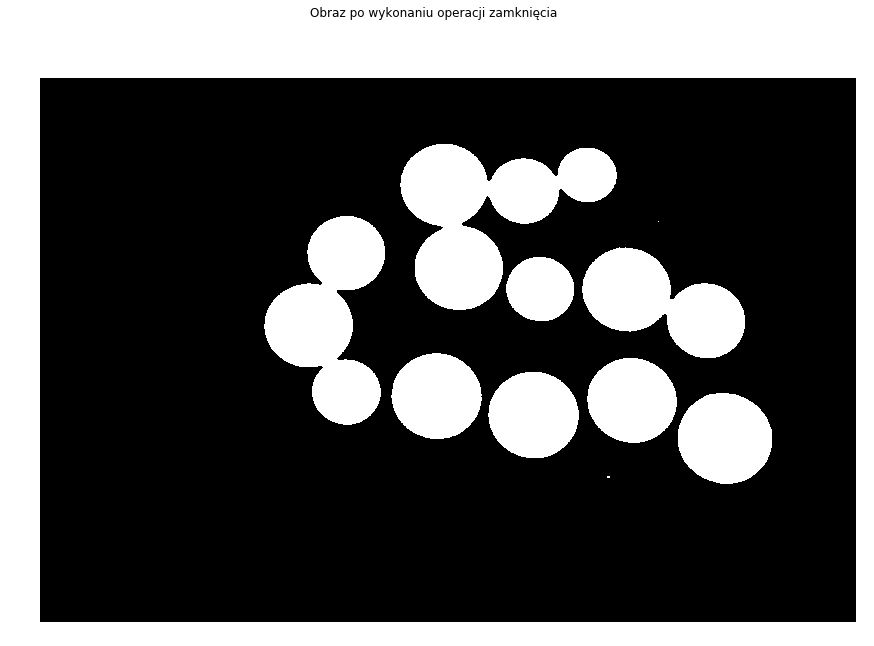

In [5]:
th = 128
th, bim = cv2.threshold(processedimg, thresh=th, maxval=255, type=cv2.THRESH_OTSU)
processedimg = bim
showimg(processedimg, title="Obraz poddany binaryzacji metodą Otsu")

morphKernel = np.ones((3,3),np.uint8)
morph2Kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (7,7))
# processedimg = cv2.morphologyEx(processedimg, op=cv2.MORPH_ERODE, kernel=morphKernel, iterations=1)
processedimg = cv2.morphologyEx(processedimg, op=cv2.MORPH_CLOSE, kernel=morph2Kernel, iterations=2)
# processedimg = cv2.morphologyEx(processedimg, op=cv2.MORPH_OPEN, kernel=morph2Kernel, iterations=5)

showimg(processedimg, title="Obraz po wykonaniu operacji zamknięcia")


14


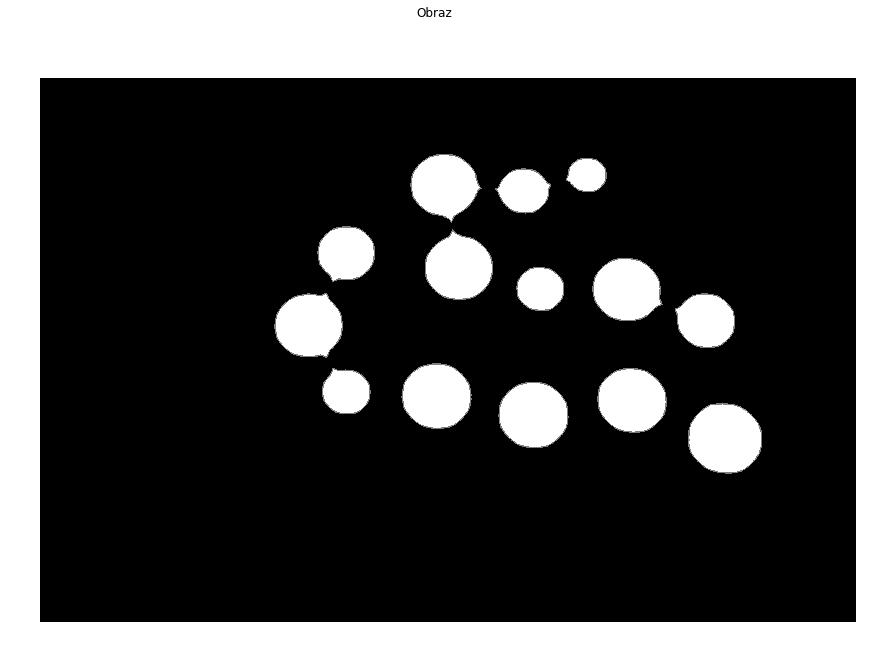

In [29]:
dtimg = dist_transform(processedimg, min_dist=36)
im2, contours, hierarchy = cv2.findContours(dtimg, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
print(len(contours))
showimg(cv2.drawContours(im2, contours, -1, (127,127,127), 3))